In [1]:
# Import libraries
import os,cv2
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Input
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras import callbacks
from keras import backend as K
K.set_image_data_format('channels_last')  
from sklearn.metrics import classification_report,confusion_matrix
import itertools
from keras.models import Model
from tensorflow.keras.applications.resnet import ResNet50

Set path for application

In [2]:
data_path = 'D:/Harold/MyDNN/DataSet/Chest_xray_seperate'
data_dir_list = os.listdir(data_path)
print(data_path)

D:/Harold/MyDNN/DataSet/Chest_xray_seperate


Set Image Size and Epocs

In [3]:
img_rows=128
img_cols=128
num_channel=3
num_epoch=100

Define the number of classes

In [4]:
num_classes = 2

img_data_list=[]

In [5]:
def preprocess_input(x):
    x[:, :, :, 0] -= 103.939
    x[:, :, :, 1] -= 116.779
    x[:, :, :, 2] -= 123.68
    # 'RGB'->'BGR'
    x = x[:, :, :, ::-1]
    return x

def data_preperation():
    for dataset in data_dir_list:
        img_list=os.listdir(data_path+'/'+ dataset)
        print ('Loading the images of dataset-'+'{}\n'.format(dataset))
        for img in img_list:
            img_path = data_path + '/'+ dataset + '/'+ img 
            img = image.load_img(img_path, target_size=(224, 224))
            x = image.img_to_array(img)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
#             print('Input image shape:', x.shape)
            img_data_list.append(x)
        print('Loading Complete')
        
#     for dataset in data_dir_list:
#         img_list=os.listdir(data_path+'/'+ dataset)
#         print ('Loading the images of dataset-'+'{}\n'.format(dataset))
#         for img in img_list:
#             img_path = data_path + '/'+ dataset + '/'+ img
#             img = image.load_img(img_path, target_size=(224, 224))
#             x = image.img_to_array(img)
#             x = np.expand_dims(x, axis=0)
#             x = preprocess_input(x)
# #             print('Input image shape:', x.shape)
#             img_data_list.append(x)
#         print('Loading Complete')

def display_loss_accuracy(hist):
    train_loss=hist.history['loss']
    val_loss=hist.history['val_loss']
    train_acc=hist.history['accuracy']
    val_acc=hist.history['val_accuracy']
    xc=range(num_epoch)

    plt.figure(1,figsize=(7,5))
    plt.plot(xc,train_loss)
    plt.plot(xc,val_loss)
    plt.xlabel('num of Epochs')
    plt.ylabel('loss')
    plt.title('train_loss vs val_loss')
    plt.grid(True)
    plt.legend(['train','val'])
    #print plt.style.available # use bmh, classic,ggplot for big pictures
    plt.style.use(['classic'])

    plt.figure(2,figsize=(7,5))
    plt.plot(xc,train_acc)
    plt.plot(xc,val_acc)
    plt.xlabel('num of Epochs')
    plt.ylabel('accuracy')
    plt.title('train_acc vs val_acc')
    plt.grid(True)
    plt.legend(['train','val'],loc=4)
    #print plt.style.available # use bmh, classic,ggplot for big pictures
    plt.style.use(['classic'])

def get_featuremaps(model, layer_idx, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()],[model.layers[layer_idx].output,])
    activations = get_activations([X_batch,0])
    return activations

def plot_featuremap_activations(activations):
    print (np.shape(activations))
    feature_maps = activations[0][0]      
    print (np.shape(feature_maps))
    print (feature_maps.shape)

    fig=plt.figure(figsize=(16,16))
    plt.imshow(feature_maps[:,:,filter_num],cmap='gray')
    plt.savefig("featuremaps-layer-{}".format(layer_num) + "-filternum-{}".format(filter_num)+'.jpg')

    num_of_featuremaps=feature_maps.shape[2]
    fig=plt.figure(figsize=(16,16))	
    plt.title("featuremaps-layer-{}".format(layer_num))
    subplot_num=int(np.ceil(np.sqrt(num_of_featuremaps)))
    for i in range(int(num_of_featuremaps)):
        ax = fig.add_subplot(subplot_num, subplot_num, i+1)
        #ax.imshow(output_image[0,:,:,i],interpolation='nearest' ) #to see the first filter
        ax.imshow(feature_maps[:,:,i],cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()
    plt.show()
    fig.savefig("featuremaps-layer-{}".format(layer_num) + '.jpg')
    
# Plotting the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Data Preperation

In [6]:
# Calling Data Preperation
data_preperation()

Loading the images of dataset-NORMAL

Loading Complete
Loading the images of dataset-PNEUMONIA

Loading Complete


In [7]:
print (len(img_data_list))
img_data = np.array(img_data_list)
#img_data = img_data.astype('float32')
print (img_data.shape)
img_data=np.rollaxis(img_data,1,0)
print (img_data.shape)
img_data=img_data[0]
print (img_data.shape)

5856
(5856, 1, 224, 224, 3)
(1, 5856, 224, 224, 3)
(5856, 224, 224, 3)


Assiging Labels

In [8]:
num_of_samples = img_data.shape[0]
labels = np.ones((num_of_samples,),dtype='int64')

labels[0:1582]=0
labels[1583:5856]=1

names = ['normal','pneumonia']

Creating clasas labels to one-hot encoding

In [9]:
# convert class labels to on-hot encoding
Y = np_utils.to_categorical(labels, num_classes)

Split Data set into training and validation set

In [10]:
#Shuffle the dataset
x,y = shuffle(img_data,Y, random_state=2)
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=2)

Model Definition

Training the classifier alone

In [11]:
image_input = Input(shape=(224, 224, 3))
model = ResNet50(input_tensor=image_input, include_top=True,weights='imagenet')
model.summary()
last_layer = model.get_layer('avg_pool').output
x= Flatten(name='flatten')(last_layer)
out = Dense(num_classes, activation='softmax', name='output_layer')(x)
custom_resnet_model = Model(inputs=image_input,outputs= out)
custom_resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [12]:
for layer in custom_resnet_model.layers[:-1]:
    layer.trainable = False

custom_resnet_model.layers[-1].trainable

True

In [13]:
custom_resnet_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [14]:
t=time.time()
hist = custom_resnet_model.fit(X_train, y_train, batch_size=32, epochs=num_epoch, verbose=1, validation_data=(X_test, y_test))
print('Training time: %s' % (t - time.time()))
(loss, accuracy) = custom_resnet_model.evaluate(X_test, y_test, batch_size=10, verbose=1)
print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

Epoch 1/100
147/147 [==============================] - 11s 73ms/step - loss: 0.2067 - accuracy: 0.9142 - val_loss: 0.1091 - val_accuracy: 0.9616
Epoch 2/100
147/147 [==============================] - 10s 65ms/step - loss: 0.1197 - accuracy: 0.9554 - val_loss: 0.0955 - val_accuracy: 0.9676
Epoch 3/100
147/147 [==============================] - 10s 65ms/step - loss: 0.0949 - accuracy: 0.9661 - val_loss: 0.1064 - val_accuracy: 0.9582
Epoch 4/100
147/147 [==============================] - 10s 65ms/step - loss: 0.0924 - accuracy: 0.9654 - val_loss: 0.0828 - val_accuracy: 0.9718
Epoch 5/100
147/147 [==============================] - 10s 65ms/step - loss: 0.0836 - accuracy: 0.9686 - val_loss: 0.0833 - val_accuracy: 0.9753
Epoch 6/100
147/147 [==============================] - 10s 65ms/step - loss: 0.0743 - accuracy: 0.9733 - val_loss: 0.0775 - val_accuracy: 0.9761
Epoch 7/100
147/147 [==============================] - 10s 65ms/step - loss: 0.0727 - accuracy: 0.9757 - val_loss: 0.0867 - val_ac

In [15]:
(loss, accuracy) = custom_resnet_model.evaluate(X_test, y_test, batch_size=10, verbose=1)

print("[INFO] loss={:.4f}, accuracy: {:.4f}%".format(loss,accuracy * 100))

118/118 [==============================] - 3s 23ms/step - loss: 0.1323 - accuracy: 0.9744
[INFO] loss=0.1323, accuracy: 97.4403%


visualizing losses and accuracy 

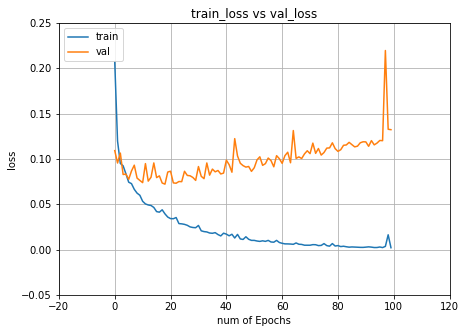

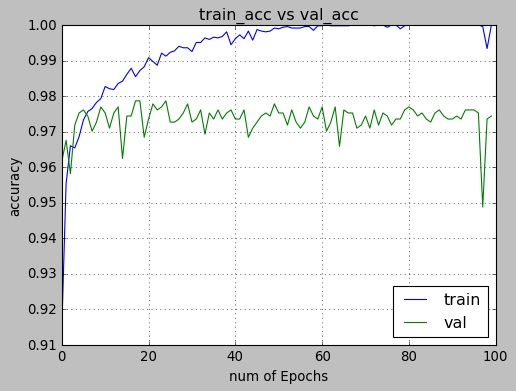

In [16]:
display_loss_accuracy(hist)

# Evaluating the model

In [17]:
score = custom_resnet_model.evaluate(X_test, y_test, verbose=0)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

test_image = X_test[0:1]
print (test_image.shape)

print(model.predict(test_image))
print(model.predict_classes(test_image))
print(y_test[0:1])

Test Loss: 0.13225294649600983
Test accuracy: 0.9744027256965637
(1, 224, 224, 3)
[[4.82067890e-07 2.68882036e-06 2.46438071e-06 1.46347942e-04
  1.14383847e-05 4.81724349e-08 2.50176436e-06 1.93318300e-07
  1.12078631e-07 1.33230387e-07 1.55274762e-07 4.57866662e-07
  8.66559446e-07 2.24399500e-07 6.64423965e-08 1.10845995e-07
  1.35442542e-06 5.03833007e-07 1.79790817e-07 6.47744287e-07
  3.05023384e-08 9.56223190e-08 1.10445868e-07 1.10137853e-06
  7.54676677e-08 4.63201928e-07 2.87497016e-07 7.07335062e-08
  5.35643494e-07 1.51549584e-05 2.59477027e-08 2.91564879e-06
  7.73133081e-07 4.95935637e-07 1.98538643e-07 2.52716568e-08
  1.83687155e-06 7.88459204e-07 3.27636599e-07 1.85687998e-06
  1.74747020e-05 5.42289399e-07 8.17253891e-08 6.31402060e-08
  3.37520163e-07 1.02205229e-06 7.63697062e-06 5.59314408e-08
  7.33921922e-07 4.65218932e-07 4.84302063e-06 6.55129497e-08
  2.73576143e-06 3.79595463e-06 7.06228604e-07 5.70710426e-06
  9.65091203e-07 2.63103260e-07 4.50051573e-07 6.2

AttributeError: 'Functional' object has no attribute 'predict_classes'

Testing a new image

In [18]:
test_image_path = 'D:/Harold/MyDNN/DataSet/Chest_xray_seperate/PNEUMONIA/person11_bacteria_45.jpeg'
test_image = image.load_img(test_image_path, target_size=(224, 224))
x = image.img_to_array(test_image)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
print (x.shape)    

            
# if num_channel==1:
#     if (K.image_data_format() == 'channels_first'):
#         test_image= np.expand_dims(test_image, axis=0)
#         test_image= np.expand_dims(test_image, axis=0)
#         print (test_image.shape)
#     else:
#         test_image= np.expand_dims(test_image, axis=3) 
#         test_image= np.expand_dims(test_image, axis=0)
#         print (test_image.shape)
# else:
#     if (K.image_data_format() == 'channels_first'):
#         test_image=np.rollaxis(test_image,2,0)
#         test_image= np.expand_dims(test_image, axis=0)
#         print (test_image.shape)
#     else:
#         test_image= np.expand_dims(test_image, axis=0)
#         print (test_image.shape)
        
        
# Predicting the test image
print((custom_resnet_model.predict(x)))
# print(custom_resnet_model.predict_classes(x))


(1, 224, 224, 3)
[[7.928144e-08 9.999999e-01]]


Visualizing the intermediate layer

(1, 2)


IndexError: invalid index to scalar variable.

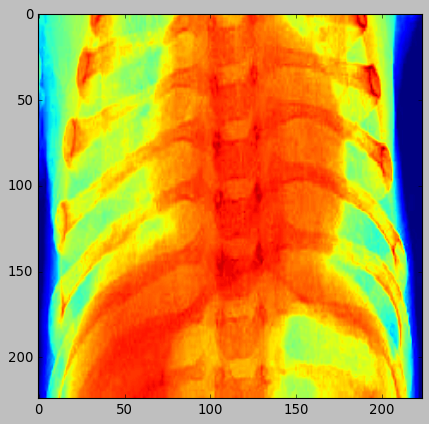

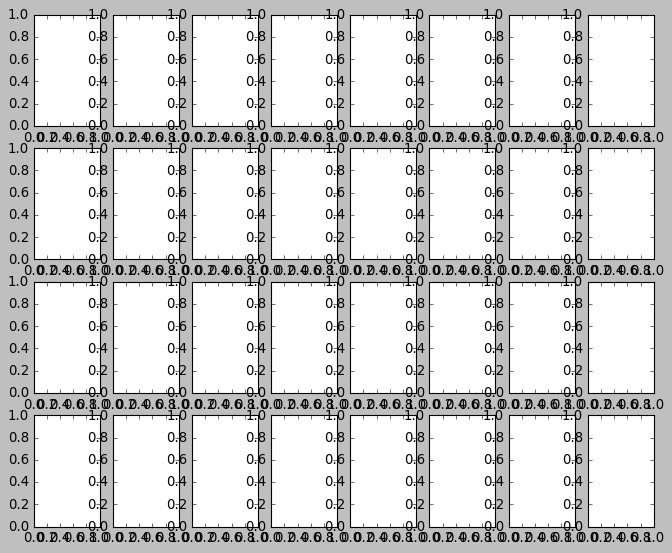

In [19]:
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=custom_resnet_model.input, outputs=layer_outputs)
activations = custom_resnet_model.predict(X_train[10].reshape(1,224,224,3))
print(activations.shape)
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[0, act_index]
    activation_index=1
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1
plt.imshow(test_image)
plt.imshow(X_train[10][:,:,0]);
display_activation(activations, 8, 4, 1)

Confusion matrix

In [21]:
Y_pred = custom_resnet_model.predict(X_test)
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)
#y_pred = model.predict_classes(X_test)
#print(y_pred)
target_names = ['class 0(Normal)', 'class 1(Pneumonia)']
print(classification_report(np.argmax(y_test,axis=1), y_pred,target_names=target_names))
print(confusion_matrix(np.argmax(y_test,axis=1), y_pred))

[[9.9328565e-07 9.9999905e-01]
 [1.0000000e+00 6.4503549e-16]
 [1.3406505e-04 9.9986589e-01]
 ...
 [1.9769919e-10 1.0000000e+00]
 [7.7234494e-09 1.0000000e+00]
 [9.9999988e-01 9.0127173e-08]]
[1 0 1 ... 1 1 0]
                    precision    recall  f1-score   support

   class 0(Normal)       0.94      0.96      0.95       312
class 1(Pneumonia)       0.99      0.98      0.98       860

          accuracy                           0.97      1172
         macro avg       0.96      0.97      0.97      1172
      weighted avg       0.97      0.97      0.97      1172

[[301  11]
 [ 19 841]]


Compute confusion matrix

Confusion matrix, without normalization
[[301  11]
 [ 19 841]]


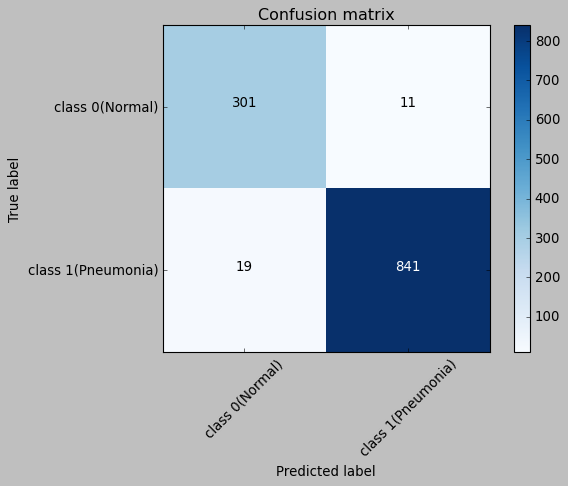

In [22]:
# Compute confusion matrix
cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')